# Experiments in heteroskedasticity and bias correction using linear transformations

This notebook works through an idea for correcting heteroskedasticity which uses rotation matrices to align samples. Previous iterations of seqpyplot (SPPLOT v0.3 and below) output a scatter plot that plots the expression values of control and treated samples and against their means. These plots revealed what appeared to be a bias where one sample tended towards overall higher expression than the other. Given the type of data being analyzed (Time series RNA seq data), it seemedunlikely that there would be such a bias inherent to the experiment.

In this notebook, I propose a method for correcting this bias using linear regression and linear transformations to rotate one of the two samples prior to differential experesssion inference. 

The steps to performing this transformation are as follows
1. For a given sample pair, compute the mean. 
2. For each sample and its repestive mean computed in step 1, perform linear regression to compute a regression coefficient (a line of best fit) through the sample/mean pair as well as a bias.
3. Zero out the sample bias by addition or subtraction across all points.
4. If the regression coeffieicients do not match, use the coefficients to compute the angle difference.
5. Compute a rotation matrix to rotate the data about the origin until they match, resulting in proper alignment between the control and treated samples.


References:
    Rotation Matrices: https://en.wikipedia.org/wiki/Rotation_matrix

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from random import randint as rand
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import euclidean_distances

from scipy.linalg import svd

from seqpyplot.container.data_container import DataContainer
from seqpyplot.parsers.config_parser import config_parser
from pathlib import Path

from matplotlib import rcParams

rcParams['figure.figsize'] = (10, 10)

pd.options.mode.chained_assignment = None 












# Helper functions

In [2]:
def calc_theta(coef1, coef2):
    "Returns an angle in radians"
    return np.abs(
       np.arctan(np.abs(coef1 - coef2) / (1. + (coef1 * coef2)))
   )

In [3]:
def compute_rot_mat(rad, coef=.5):
    " Compute a rotation matrix using rad for a given regression coefficient "
    if coef < 1.0:
        rotation_matrix = np.array([[np.cos(rad), -np.sin(rad)],
                                    [np.sin(rad), np.cos(rad)]])
    else:
        rotation_matrix = np.array([[np.cos(rad), np.sin(rad)],
                                    [-np.sin(rad), np.cos(rad)]])  
    return rotation_matrix

# Experiment 1: Simple example of line rotation
Example of rotating a line around the origin to match the slope of another line

In [4]:
slope1 = 1.1
slope2 = 2.0

line1 = np.array([slope1 * x for x in range(10)])
line2 = np.array([slope2 * x for x in range(10)])

xs = list(range(10))

#### Original Lines

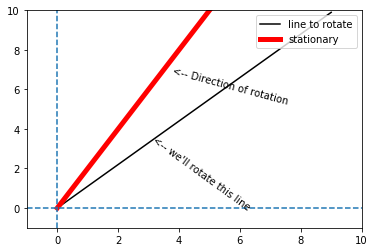

In [5]:
# Plot lines
plt.plot(xs, line1, color='black', label='line to rotate');
plt.plot(xs, line2, color='red', linewidth=5, label='stationary');
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--');

plt.annotate(s=('<-- we\'ll rotate this line'), xy=(xs[3]+0.08, line1[3]), rotation=-36)
plt.annotate(s=('<-- Direction of rotation'), xy=(xs[3] + 0.75, line1[3]+3.5), rotation=-15)

plt.ylim((-1, 10))
plt.xlim((-1, 10))
plt.legend(loc='upper right');

#### Rotated lines

In [6]:
# Compute angle
angle_diff = calc_theta(slope1, slope2)
angle_diff

0.27416745111965873

In [7]:
# Compute rotation matrix
rot_matrix = compute_rot_mat(angle_diff)
rot_matrix

array([[ 0.96265094, -0.27074558],
       [ 0.27074558,  0.96265094]])

In [11]:
# rotate line 1 (black line)
new_line1 = list()
for x, y in zip(xs, line1):
    # need shape [[#], [#]]
    old_point = np.array([[x], [y]])
    new_point = np.dot(old_point, rot_matrix)
    new_line1.append(new_point)
new_line1 = np.squeeze(np.asarray(new_line1))

ValueError: shapes (2,1) and (2,2) not aligned: 1 (dim 1) != 2 (dim 0)

In [12]:
xs[6], line1[6]

(6, 6.6000000000000005)

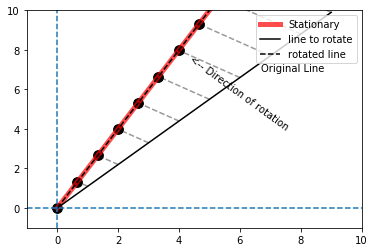

In [10]:
plt.plot(xs, line2, color='red', linewidth=5, alpha=0.7, label='Stationary');

plt.plot(xs, line1, color='black', label='line to rotate')
plt.scatter(new_line1[:, 0], new_line1[:, 1], color='black', s=95)
plt.plot(new_line1[:, 0], new_line1[:, 1], color='black', linestyle='--', label='rotated line')

plt.annotate(s=('Original Line'), xy=(xs[6] + 0.7, line1[6]+0.3))
plt.annotate(s=('<-- Direction of rotation'), xy=(xs[6] - 1.7, line1[6]+0.8), rotation=-36)

plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')

for (x1, y1), (x2, y2) in zip(zip(xs, line1), new_line1):
    plt.plot([x1, x2], [y1, y2], linestyle='--', color='black', alpha=0.4)

plt.ylim((-1, 10))
plt.xlim((-1, 10));
plt.legend(loc='upper right');

# Experiment 2: Vanilla correction using linear regression on raw expression Data
(No TMM normalization)

In [12]:
config = '../examples/example_config.ini'
config_obj = config_parser(config)

In [13]:
# load the data container_obj
container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

In [14]:
cols = data.columns
cols

Index(['D1_Cont', 'D2_Cont', 'D3_Cont', 'D1_Treat', 'D2_Treat', 'D3_Treat'], dtype='object')

In [15]:
df = data[['D1_Cont', 'D1_Treat']]
df.loc[:, 'mean'] = df.mean(axis=1)

In [16]:
df.head()

,D1_Cont,D1_Treat,mean
gene,,,
0610005C13Rik,16,30,23.0
0610007P14Rik,333,364,348.5
0610009B22Rik,150,220,185.0
0610009L18Rik,20,25,22.5
0610009O20Rik,680,805,742.5


In [17]:
d1 = df[['D1_Cont', 'mean']]
d2 = df[['D1_Treat', 'mean']]

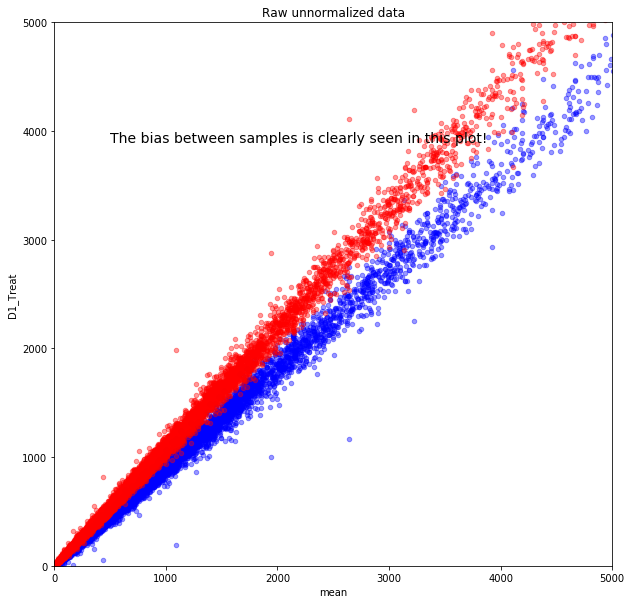

In [18]:
fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='blue', alpha=0.4)
d2.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
plt.annotate('The bias between samples is clearly seen in this plot!', (500, 3900), fontsize=14)
ax.set_title("Raw unnormalized data");

No handles with labels found to put in legend.


[[1.10159719]] [-1.68423257]
[[0.9083203]] [5.21303275]


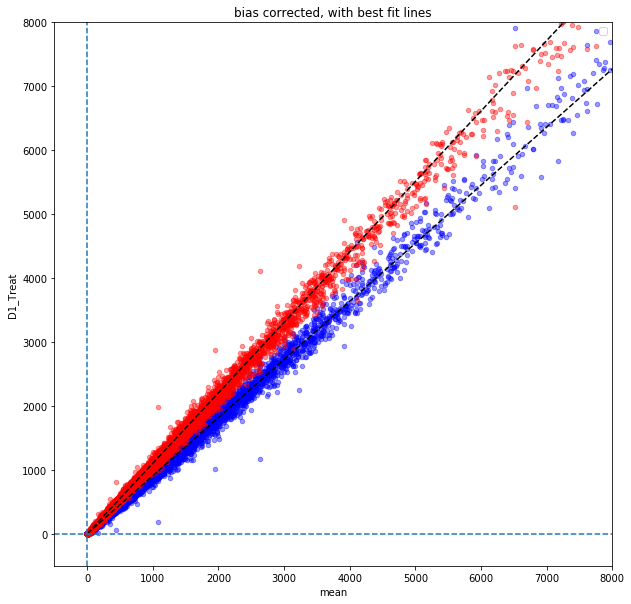

In [19]:
# Quick reset for this cell
d1 = df[['D1_Cont', 'mean']]
d2 = df[['D1_Treat', 'mean']]

# define regression objects
regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

# fit regression
regCont.fit(d1['D1_Cont'].values.reshape(-1, 1), d1['mean'].values.reshape(-1, 1))
regTreat.fit(d2['D1_Treat'].values.reshape(-1, 1), d1['mean'].values.reshape(-1, 1))

print(regCont.coef_, regCont.intercept_)
print(regTreat.coef_, regTreat.intercept_)

# Correct bias
d1['D1_Cont'] = d1['D1_Cont'] - regCont.intercept_
d2['D1_Treat'] = d2['D1_Treat'] - regTreat.intercept_

# Plot regression lines
fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', ax=ax, color='blue', alpha=0.4)
d2.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 8000), ylim=(0, 8000), ax=ax, color='red',  alpha=0.4)
plt.plot([0, 8000], [0.0, regCont.coef_ * 8000], linestyle='--', color='black')
plt.plot([0, 8000], [0.0, regTreat.coef_ * 8000], linestyle='--', color='black');
ax.set_title("bias corrected, with best fit lines");

plt.ylim((-500, 8000))
plt.xlim((-500, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

#### Compute rotation linear transformation

No handles with labels found to put in legend.


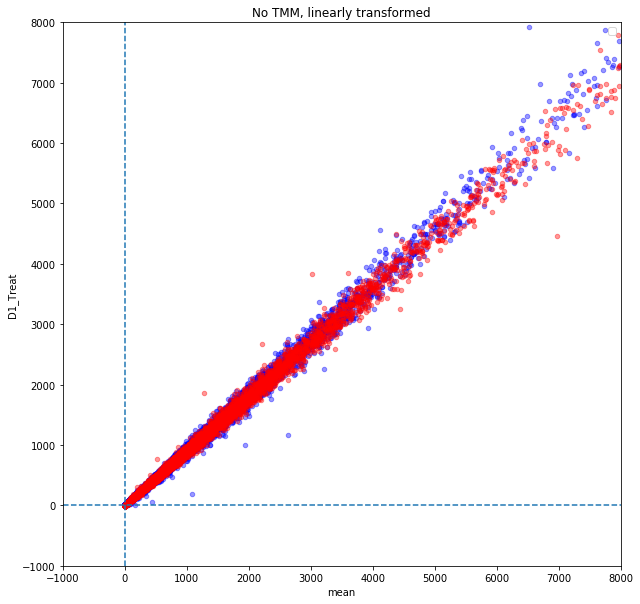

In [20]:
correction_theta = calc_theta(np.squeeze(regCont.coef_), np.squeeze(regTreat.coef_))
correction_theta  # in radians

rotation_matrix = compute_rot_mat(correction_theta)
rotation_matrix

new_treat = np.array([np.dot(rotation_matrix, d2.values[i, :]) for i in range(len(d2.values))])
new_treat

d2_cor = d2.copy()
d2_cor.loc[:, 'D1_Treat'] = new_treat[:, 0]
d2_cor.loc[:, 'mean'] = new_treat[:, 1]

fig, ax = plt.subplots()
d1.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 20000), ylim=(0, 20000), ax=ax, color='blue', alpha=0.4)
d2_cor.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
ax.set_title("No TMM, linearly transformed")

plt.ylim((-1000, 8000))
plt.xlim((-1000, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

Successs! We have eliminated the sample divergence!

# Experiment 3: Use TMM before linear transformation

There could still be advantage in normalizing the samples prior to performing the linear transformation.

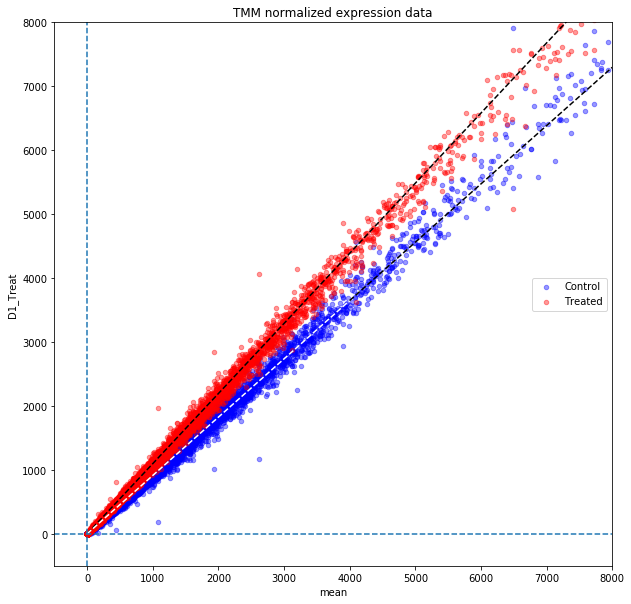

In [21]:
# load the data container_obj
config = '../examples/example_config.ini'
config_obj = config_parser(config)

container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

data = container_obj.normalize_file_pairs(data) # Single df of normalized data

normed_df = data[['D1_Cont', 'D1_Treat']].copy()
normed_df.loc[:, 'mean'] = normed_df.mean(axis=1)
 
regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

regCont.fit(normed_df['D1_Cont'].values.reshape(-1, 1), normed_df['mean'].values.reshape(-1, 1))
regTreat.fit(normed_df['D1_Treat'].values.reshape(-1, 1), normed_df['mean'].values.reshape(-1, 1))

normed_df['D1_Cont'] = normed_df['D1_Cont'] - regCont.intercept_
normed_df['D1_Treat'] = normed_df['D1_Treat'] - regTreat.intercept_

fig, ax = plt.subplots()
normed_df.plot('mean', 'D1_Cont', kind='scatter',
               xlim=(0, 5000), ylim=(0, 8000), ax=ax, color='blue', alpha=0.4, label='Control')
normed_df.plot('mean', 'D1_Treat', kind='scatter',
               xlim=(0, 5000), ylim=(0, 8000), ax=ax, color='red', alpha=0.4, label='Treated')

# plot regression lines, with color switch!
plt.plot([0, 8000], [0.0, regCont.coef_ * 8000], linestyle='--', color='black')
plt.plot([0, 4000], [0.0, regTreat.coef_ * 4000], linestyle='--', color='white');
plt.plot([4000, 8000], [regTreat.coef_[0] * 4000.0, regTreat.coef_[0] * 8000], linestyle='--', color='black');

ax.set_title("TMM normalized expression data");

plt.ylim((-500, 8000))
plt.xlim((-500, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

#### Compute linear transformation

No handles with labels found to put in legend.


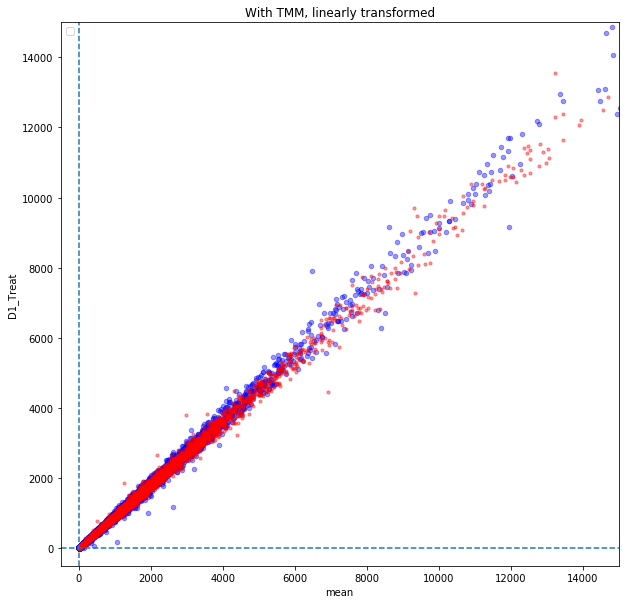

In [22]:
correction_theta = calc_theta(np.squeeze(regCont.coef_), np.squeeze(regTreat.coef_))
rotation_matrix = compute_rot_mat(correction_theta, regTreat.coef_)

new_treat = np.array([np.dot(rotation_matrix, normed_df[['D1_Treat', 'mean']].values[i, :]) for i in range(len(normed_df))])

corr_df = normed_df.copy()
corr_df.loc[:, 'D1_Treat'] = new_treat[:, 0]
# corr_df.loc[:, 'mean'] = normed_df['mean'].values
corr_df.loc[:, 'mean'] = new_treat[:, 1]

fig, ax = plt.subplots()
normed_df.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 20000), ylim=(0, 20000), ax=ax, color='blue', alpha=0.4)
corr_df.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4, s=10);
ax.set_title("With TMM, linearly transformed");

plt.ylim((-500, 15000))
plt.xlim((-500, 15000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

# Experiment 4: Before linear regression, remove zeros and remove 80% percentile outliers

In [23]:
data_copy = data.copy()[['D1_Cont', 'D1_Treat']]

In [24]:
percentiles = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 0.95, 0.99]

In [25]:
data_copy.describe(percentiles=percentiles)

,D1_Cont,D1_Treat
count,24421.000000,24421.000000
mean,440.533025,522.181097
std,1709.280643,2057.033816
min,0.000000,0.000000
10%,0.000000,0.000000
20%,0.000000,0.000000
30%,1.000000,1.982922
40%,8.000000,10.906071
50%,37.000000,46.598668
60%,128.000000,157.642303


In [26]:
data_copy2 = data_copy[(data_copy.D1_Cont != 0) & (data_copy.D1_Treat != 0)]

In [27]:
(data_copy2.D1_Cont - data_copy2.D1_Treat).abs().describe(percentiles=percentiles)

count    17413.000000
mean       118.628888
std        501.171407
min          0.000940
10%          1.232260
20%          3.906071
30%          7.923149
40%         16.307591
50%         30.146102
60%         51.905662
70%         89.379457
80%        148.856103
90%        291.579137
95%        481.717673
99%       1106.296371
max      45032.123359
dtype: float64

In [28]:
(data_copy2.D1_Cont - data_copy2.D1_Treat).abs().describe(percentiles=percentiles).loc['80%']

148.85610341677005

In [29]:
data_copy3 = (data_copy2.D1_Cont - data_copy2.D1_Treat).abs()

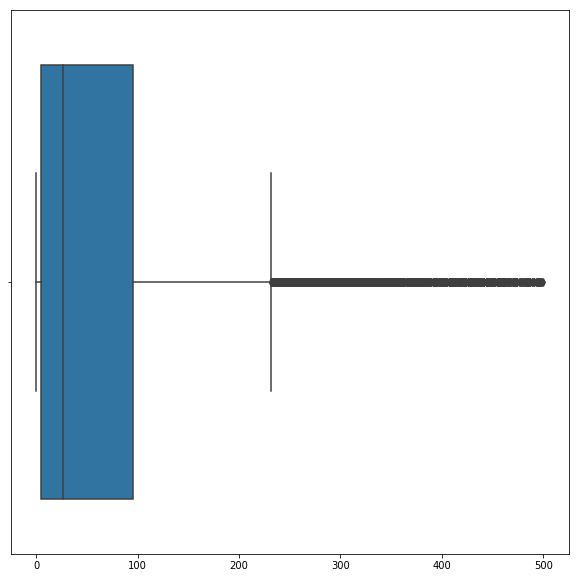

In [30]:
sns.boxplot(data_copy3[data_copy3 < 500]);

In [31]:
data_copy2.head()

,D1_Cont,D1_Treat
gene,,
0610005C13Rik,16.0,29.743831
0610007P14Rik,333.0,360.891812
0610009B22Rik,150.0,218.121425
0610009L18Rik,20.0,24.786526
0610009O20Rik,680.0,798.126123


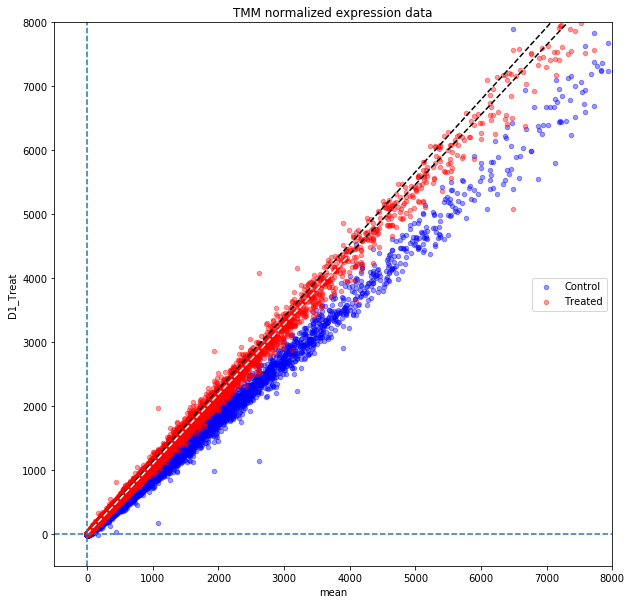

In [32]:
# load the data container_obj
config = '../examples/example_config.ini'
config_obj = config_parser(config)

container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

data = container_obj.normalize_file_pairs(data) # Single df of normalized data

#----------------------------------------------------------
data_copy = data.copy()
data_copy.loc[:, 'mean'] = data_copy.mean(axis=1)

data_copy = data_copy[(data_copy.D1_Cont != 0) & (data_copy.D1_Treat != 0)]
data_copy.loc[:, 'abs_diff'] = (data_copy.D1_Cont - data_copy.D1_Treat).abs()
cutoff = (data_copy.D1_Cont - data_copy.D1_Treat).abs().describe(percentiles=percentiles).loc['80%']
data_copy = data_copy[data_copy['abs_diff'] < cutoff]

regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

regCont.fit(data_copy['D1_Cont'].values.reshape(-1, 1), data_copy['mean'].values.reshape(-1, 1))
regTreat.fit(data_copy['D1_Treat'].values.reshape(-1, 1), data_copy['mean'].values.reshape(-1, 1))

#----------------------------------------------------------
normed_df = data.copy()
normed_df = normed_df[['D1_Cont', 'D1_Treat']].copy()
normed_df.loc[:, 'mean'] = normed_df.mean(axis=1)

normed_df['D1_Cont'] = normed_df['D1_Cont'] - regCont.intercept_
normed_df['D1_Treat'] = normed_df['D1_Treat'] - regTreat.intercept_

fig, ax = plt.subplots()
normed_df.plot('mean', 'D1_Cont', kind='scatter',
               xlim=(0, 5000), ylim=(0, 8000), ax=ax, color='blue', alpha=0.4, label='Control')
normed_df.plot('mean', 'D1_Treat', kind='scatter',
               xlim=(0, 5000), ylim=(0, 8000), ax=ax, color='red', alpha=0.4, label='Treated')

# plot regression lines, with color switch!
plt.plot([0, 8000], [0.0, regCont.coef_ * 8000], linestyle='--', color='black')
plt.plot([0, 4000], [0.0, regTreat.coef_ * 4000], linestyle='--', color='white');
plt.plot([4000, 8000], [regTreat.coef_[0] * 4000.0, regTreat.coef_[0] * 8000], linestyle='--', color='black');

ax.set_title("TMM normalized expression data");

plt.ylim((-500, 8000))
plt.xlim((-500, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

In [33]:
correction_theta = calc_theta(np.squeeze(regCont.coef_), np.squeeze(regTreat.coef_))
rotation_matrix = compute_rot_mat(correction_theta)

regCont.coef_, regTreat.coef_

normed_df.head()

,D1_Cont,D1_Treat,mean
gene,,,
0610005C13Rik,-7.764035,29.319262,22.871915
0610007P14Rik,309.235965,360.467244,346.945906
0610009B22Rik,126.235965,217.696856,184.060712
0610009L18Rik,-3.764035,24.361957,22.393263
0610009O20Rik,656.235965,797.701554,739.063062


No handles with labels found to put in legend.


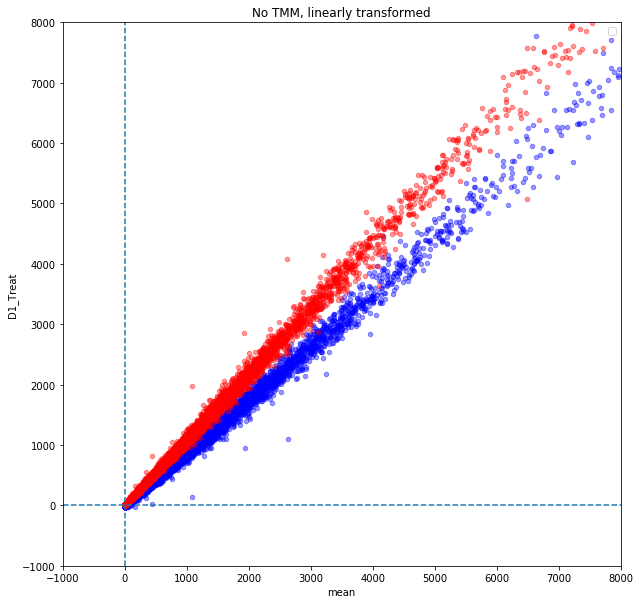

In [34]:
new_treat = np.array([np.dot(rotation_matrix, normed_df[['D1_Cont', 'mean']].values[i, :]) for i in range(len(normed_df.values))])

rotated = pd.DataFrame(new_treat, columns=['Cont_cor', 'mean_cor'], index=normed_df.index)

fig, ax = plt.subplots()
rotated.plot('mean_cor', 'Cont_cor', kind='scatter', xlim=(0, 20000), ylim=(0, 20000), ax=ax, color='blue', alpha=0.4)
normed_df.plot('mean', 'D1_Treat', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
ax.set_title("No TMM, linearly transformed")

plt.ylim((-1000, 8000))
plt.xlim((-1000, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

## Conclusion
Outlier removal doesn't provide sufficient correction. 

#  Experiment 5 - Use samples with mean ranged between interval (maybe 200 - 1200?) to compute regression coefficient.

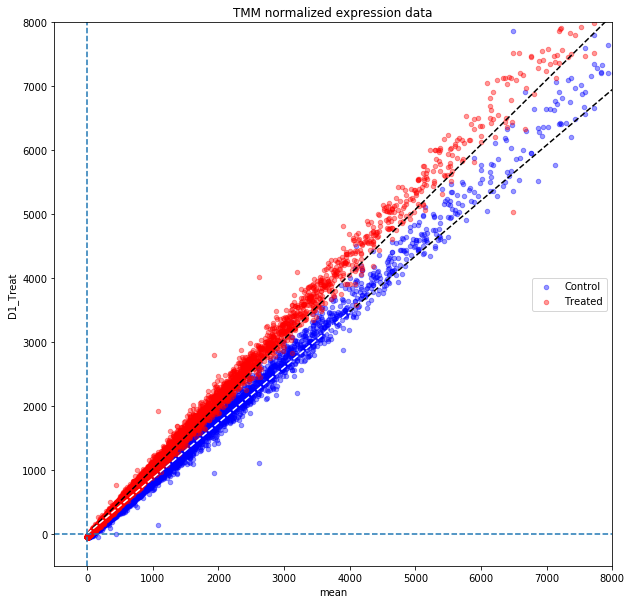

In [35]:
# load the data container_obj
config = '../examples/example_config.ini'
config_obj = config_parser(config)

container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

data = container_obj.normalize_file_pairs(data) # Single df of normalized data

#----------------------------------------------------------
data_copy = data.copy()
data_copy.loc[:, 'mean'] = data_copy.mean(axis=1)

data_copy = data_copy[(data_copy['mean'] > 100) & (data_copy['mean'] < 500)]


regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

regCont.fit(data_copy['D1_Cont'].values.reshape(-1, 1), data_copy['mean'].values.reshape(-1, 1))
regTreat.fit(data_copy['D1_Treat'].values.reshape(-1, 1), data_copy['mean'].values.reshape(-1, 1))

#----------------------------------------------------------
normed_df = data.copy()
normed_df = normed_df[['D1_Cont', 'D1_Treat']].copy()
normed_df.loc[:, 'mean'] = normed_df.mean(axis=1)

normed_df['D1_Cont'] = normed_df['D1_Cont'] - regCont.intercept_
normed_df['D1_Treat'] = normed_df['D1_Treat'] - regTreat.intercept_

fig, ax = plt.subplots()
normed_df.plot('mean', 'D1_Cont', kind='scatter',
               xlim=(0, 5000), ylim=(0, 8000), ax=ax, color='blue', alpha=0.4, label='Control')
normed_df.plot('mean', 'D1_Treat', kind='scatter',
               xlim=(0, 5000), ylim=(0, 8000), ax=ax, color='red', alpha=0.4, label='Treated')

# plot regression lines, with color switch!
plt.plot([0, 8000], [0.0, regCont.coef_ * 8000], linestyle='--', color='black')
plt.plot([0, 4000], [0.0, regTreat.coef_ * 4000], linestyle='--', color='white');
plt.plot([4000, 8000], [regTreat.coef_[0] * 4000.0, regTreat.coef_[0] * 8000], linestyle='--', color='black');

ax.set_title("TMM normalized expression data");

plt.ylim((-500, 8000))
plt.xlim((-500, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

In [36]:
correction_theta = calc_theta(np.squeeze(regCont.coef_), np.squeeze(regTreat.coef_))
rotation_matrix = compute_rot_mat(correction_theta)

In [37]:
np.squeeze(regCont.coef_), np.squeeze(regTreat.coef_)

(array(1.01405412), array(0.86825381))

In [79]:
normed_df.head()

,D1_Cont,D1_Treat,mean
gene,,,
0610005C13Rik,-40.244465,-22.030329,22.871915
0610007P14Rik,276.755535,309.117653,346.945906
0610009B22Rik,93.755535,166.347265,184.060712
0610009L18Rik,-36.244465,-26.987634,22.393263
0610009O20Rik,623.755535,746.351963,739.063062


In [80]:
coefficients

NameError: name 'coefficients' is not defined

No handles with labels found to put in legend.


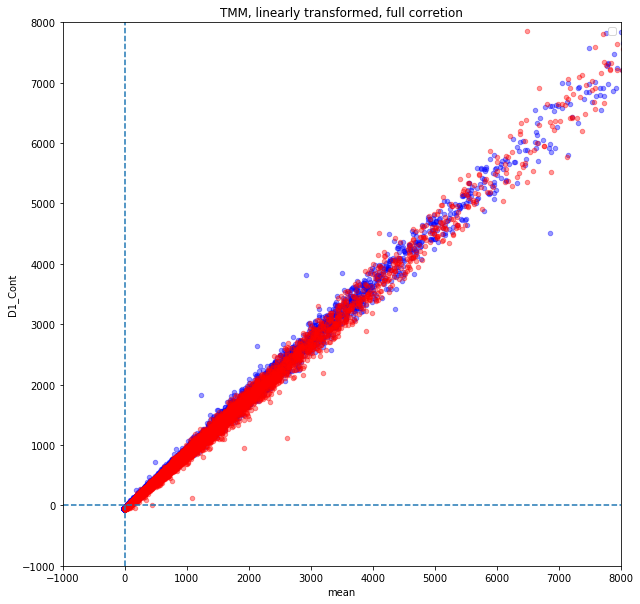

In [45]:
new_treat = np.array([np.dot(rotation_matrix, normed_df[['D1_Treat', 'mean']].values[i, :]) for i in range(len(normed_df.values))])

rotated = pd.DataFrame(new_treat, columns=['Treat_cor', 'mean_cor'], index=normed_df.index)

fig, ax = plt.subplots()
rotated.plot('mean_cor', 'Treat_cor', kind='scatter', xlim=(0, 20000), ylim=(0, 20000), ax=ax, color='blue', alpha=0.4)
normed_df.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
ax.set_title("TMM, linearly transformed, full corretion")

plt.ylim((-1000, 8000))
plt.xlim((-1000, 8000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

# Experiment 6: Visualization of correction ignoring horizontal rotation shift

No handles with labels found to put in legend.


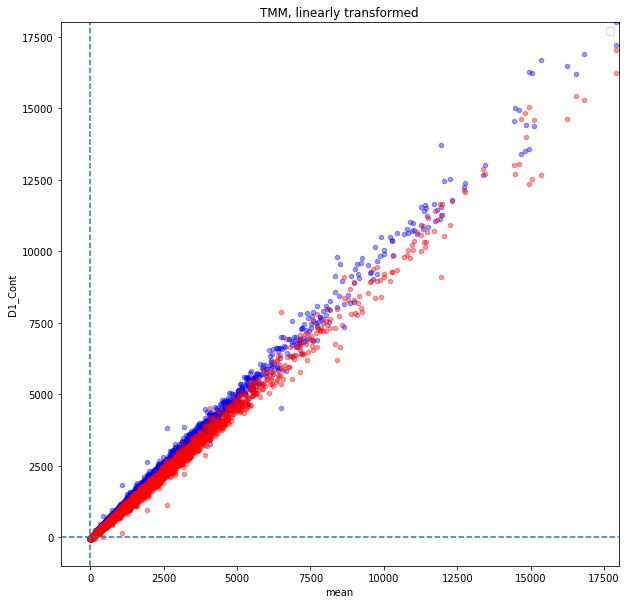

In [69]:
# load the data container_obj
config = '../examples/example_config.ini'
config_obj = config_parser(config)

container_obj = DataContainer(config_obj)
data, ercc_data = container_obj.parse_input()

data = container_obj.normalize_file_pairs(data) # Single df of normalized data

#----------------------------------------------------------
data_copy = data.copy()
data_copy.loc[:, 'mean'] = data_copy.mean(axis=1)

data_copy = data_copy[(data_copy['mean'] > 100) & (data_copy['mean'] < 500)]

regCont = LinearRegression(fit_intercept=True)
regTreat = LinearRegression(fit_intercept=True)

regCont.fit(data_copy['D1_Cont'].values.reshape(-1, 1), data_copy['mean'].values.reshape(-1, 1))
regTreat.fit(data_copy['D1_Treat'].values.reshape(-1, 1), data_copy['mean'].values.reshape(-1, 1))

#----------------------------------------------------------
normed_df = data.copy()
normed_df = normed_df[['D1_Cont', 'D1_Treat']].copy()
normed_df.loc[:, 'mean'] = normed_df.mean(axis=1)

normed_df['D1_Cont'] = normed_df['D1_Cont'] - regCont.intercept_
normed_df['D1_Treat'] = normed_df['D1_Treat'] - regTreat.intercept_

correction_theta = calc_theta(np.squeeze(regCont.coef_), np.squeeze(regTreat.coef_))
rotation_matrix = compute_rot_mat(correction_theta)

new_treat = np.array([np.dot(rotation_matrix, normed_df[['D1_Treat', 'mean']].values[i, :]) for i in range(len(normed_df.values))])

rotated = pd.DataFrame(new_treat, columns=['Treat_cor', 'mean_cor'], index=normed_df.index)
rotated.loc[:, 'mean'] = normed_df['mean']

fig, ax = plt.subplots()
rotated.plot('mean', 'Treat_cor', kind='scatter', xlim=(0, 20000), ylim=(0, 20000), ax=ax, color='blue', alpha=0.4)
normed_df.plot('mean', 'D1_Cont', kind='scatter', xlim=(0, 5000), ylim=(0, 5000), ax=ax, color='red', alpha=0.4);
ax.set_title("TMM, linearly transformed")

plt.ylim((-1000, 18000))
plt.xlim((-1000, 18000));
plt.axvline(0, linestyle='--')
plt.axhline(0, linestyle='--')
plt.legend();

In [70]:
correction_theta = calc_theta()

In [76]:
coefs = list(map(float, [np.squeeze(regTreat.coef_), np.squeeze(regCont.coef_)]))

In [77]:
coefs

[0.8682538118726439, 1.0140541203578086]

In [78]:
calc_theta(*coefs)

0.07737972370938052

In [83]:
normed_df.columns[np.argmin(coefs)]

'D1_Cont'